# Test the neural network policy in the training environment

In [1]:
using POMDPs, StatsBase, POMDPToolbox, QMDP, DeepRL, AutomotiveDrivingModels, AutoViz, SARSOP, Images, PyCall, Reel, Parameters


In [2]:
include("occluded_crosswalk_env.jl")
include("helpers.jl")
include("pomdp_types.jl")
include("constant_pedestrian.jl")
include("generative_model.jl")
include("render_helpers.jl")


...) in module Base at util.jl:532 overwritten in module Logging at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.

In [3]:
rng = MersenneTwister(1)
pomdp = OCPOMDP()

.


OCPOMDP(CrosswalkEnv(Roadway, AutomotiveDrivingModels.Lane(LaneTag(2, 1), AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 6.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[]), AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(21.500, -4.500)
	VecE2(21.500, -1.500)
], EnvParams(2, 50.0, 3.0, 20.0, 6.0, 5.0, 37.0, 8.0, 100, 0.5, 2.0, 10.0)), AutomotiveDrivingModels.LidarSensor([-1.50796, -1.44513, -1.3823, -1.31947, -1.25664, -1.19381, -1.13097, -1.06814, -1.00531, -0.942478  …  1.00531, 1.06814, 1.13097, 1.19381, 1.25664, 1.31947, 1.3823, 1.44513, 1.50796, 1.5708], [4.06439e-316, 4.06439e-316, 4.06439e-316, 4.06439e-316, 4.0643

In [4]:
@pyimport tensorflow as tf
nn_wrapper = pyimport("dqn.nn_wrapper")

PyObject <module 'dqn.nn_wrapper' from 'C:\\Users\\Maxime\\OneDrive - Leland Stanford Junior University\\Research\\policy-correction\\dqn\\nn_wrapper.py'>

In [5]:
nn = nn_wrapper[:NNWrapper]("../../dqn/single_3/", scope="multi")

INFO:tensorflow:Restoring parameters from ../../dqn/corr_21/model.ckpt


2017-11-03 11:48:47.709629: W c:\tf_jenkins\home\workspace\release-win\m\windows\py\35\tensorflow\core\platform\cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE instructions, but these are available on your machine and could speed up CPU computations.
2017-11-03 11:48:47.709663: W c:\tf_jenkins\home\workspace\release-win\m\windows\py\35\tensorflow\core\platform\cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-03 11:48:47.709687: W c:\tf_jenkins\home\workspace\release-win\m\windows\py\35\tensorflow\core\platform\cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE3 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-03 11:48:47.709697: W c:\tf_jenkins\home\workspace\release-win\m\windows\py\35\tensorflow\core\platform\cpu_feature_guard.cc:45] The TensorFlow library wasn

PyObject <dqn.nn_wrapper.NNWrapper object at 0x000000002A6EFF60>

In [6]:
function multi_to_singles(obs, nframes=4)    
    n_ped = div(size(obs,1)-2,2)
    single_obs = Vector{Array{Float64,3}}(n_ped)
    o = reshape(obs, (size(obs, 1), nframes))
    for i = 2:n_ped+1
        single_o = zeros(4, nframes)
        single_o[1,:] = o[1,:]
        single_o[2,:] = o[2,:]
        single_o[3,:] = o[2*i - 1, :]
        single_o[4,:] = o[2*i, :]
        single_o = reshape(single_o, (4,1,nframes))
        single_obs[i-1] = single_o
    end
    return single_obs
end

function get_action(pomdp, policy, o_queue, action_map)
    singles = multi_to_singles(o_queue)    
#     all_val = zeros(4, length(singles))
#     for i = 1:length(singles)
#         all_val[:, i] = policy[:value](singles[i])
# #         println(singles[i])
# #         println("\n")
#     end
#     val = minimum(all_val, 2)
    val = zeros(4)
    for o in singles
        val += policy[:value](singles[i])
    end
    return action_map[indmax(val)]
end
            
# function get_action(pomdp, policy, o_queue, action_map)
#     ai = policy[:action](o_queue)
#     return action_map[ai+1]
# end

function efficient_dequeue(queue::Array{Float64,3}, new_elem::Array{Float64,3}, nch::Int64=size(new_elem,3),nqueue::Int64=div(size(queue, 3),size(new_elem, 3)))
    # first shift all the old element
    queue = circshift(queue, (0,0,-nch))
    # enqueue the first one
    queue[:,:,(nqueue-1)*nch+1:nqueue*nch] = new_elem
    return queue
end

function preprocess_o(o::OCObs, pomdp::OCPOMDP, queue=nothing)
    nframes = 4
    o_mat = convert_o(Vector{Float64}, o, pomdp)
    o_mat = reshape(o_mat, (size(o_mat,1), 1, 1))
    if queue == nothing
        w, h, nch = size(o_mat)
        o_stacked = repeat(reshape(o_mat, (w, h, nch)), outer=(1,1,nframes))
        o_stacked = reshape(o_stacked, (w, h, nch*nframes))
        return o_stacked
    else
        queue = efficient_dequeue(queue, o_mat)
    end
    return queue
end

preprocess_o (generic function with 2 methods)

In [7]:
s = initial_state(pomdp, rng)
o_init = generate_o(pomdp, s, rng)
o_p = preprocess_o(o_init, pomdp)
get_action(pomdp, nn, o_p, actions(pomdp))

OCAction(2.0)

In [15]:
r_avg = 0
step_avg = 0
crash = 0
time_out = 0
success = 0
n_ep = 1000
max_steps = 100
saved_states = OCState[]

for i=1:n_ep    
    saved_states = OCState[]
    disc = 1.0
    r_total = 0.0    
    s = initial_state(pomdp, rng)
    a_map = actions(pomdp)
    o_init = generate_o(pomdp, s, rng)
    o = preprocess_o(o_init, pomdp)
    step = 1

    while !isterminal(pomdp, s) && step <= max_steps # TODO also check for terminal observation
        a = get_action(pomdp, nn, o, a_map)
#         println(o, "\n\n")
        sp, o_, r = generate_sor(pomdp, s, a, rng)
#         println(o_)

        push!(saved_states, sp)
        if sp.n > 7
           return sp
        end
        r_total += disc*r

        s = sp
        op = preprocess_o(o_, pomdp, o)
#         println(op)
        
        o = op

#         disc *= discount(pomdp)
        step += 1
    end
    r_avg += r_total
    if r_total <= -1.02
        crash += 1
    elseif step >= 100
        time_out += 1
#         break
    else
        success += 1
    end
    step_avg += step
#     println(r_total)
end
r_avg /= n_ep
step_avg /= n_ep

println("Average reward: $r_avg; Average # of steps: $step_avg; # of crashes: $crash; # of time out $time_out; # of successes $success")

Average reward: 0.704; Average # of steps: 17.056; # of crashes: 0; # of time out 8; # of successes 742


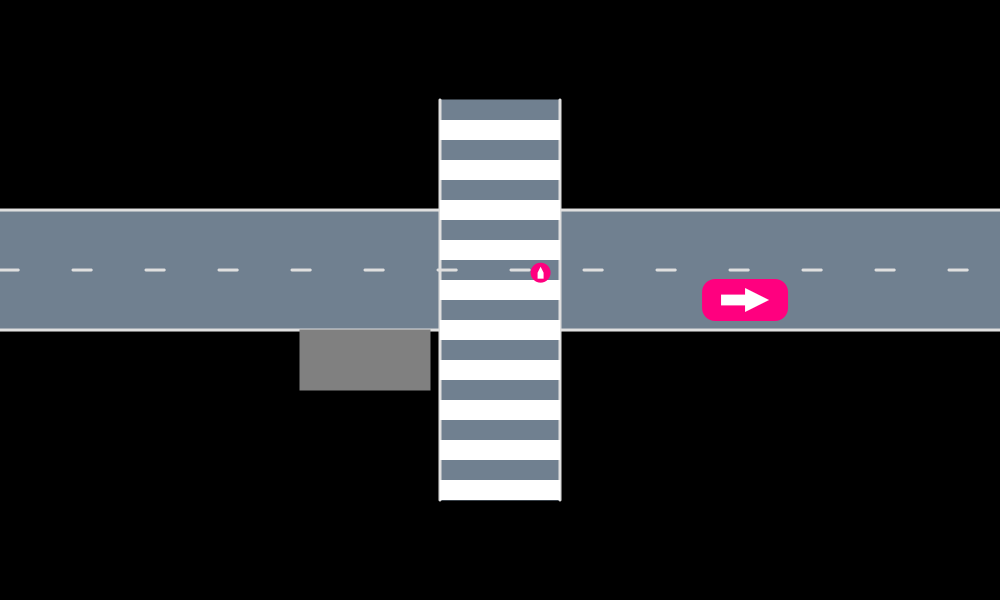

In [9]:
AutoViz.render(saved_states[end], pomdp.env, cam=FitToContentCamera(0.0))

## Visualize policy

In [10]:
using AutoViz, Reel

In [11]:
include("render_helpers.jl")

In [12]:
function animate_scenes(scenes::Vector{Scene}, pomdp)
    duration =length(scenes)*pomdp.ΔT
    fps = Int(1/pomdp.ΔT)
    cam = FitToContentCamera(0.)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        return AutoViz.render(scenes[frame_index], pomdp.env, cam=cam)
    end
    return duration, fps, render_rec
end


animate_scenes (generic function with 1 method)

In [13]:
duration, fps, render_states = animate_scenes(saved_states, pomdp)
speed_factor = 1
film = roll(render_states, fps = fps*speed_factor, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_C45.tmp", 0x000000000000001d, 2.0, nothing)

In [14]:
isterminal(pomdp, saved_states[end])

true